In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [7]:
#read the CSV file with Data ans load them into Pands\as Dataset
airlines = pd.read_csv('airline_clean_data_0722.csv')
airlines.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,US,SFO,CLT,20,18.0,-2.0,806,811.0,5.0,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,DL,SFO,MSP,25,20.0,-5.0,602,610.0,8.0,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,DL,SEA,MSP,40,39.0,-1.0,549,557.0,8.0,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,NK,LAS,MCI,55,120.0,25.0,537,543.0,6.0,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AA,SEA,MIA,100,52.0,-8.0,938,939.0,1.0,NaN,NaN,NaN,NaN,NaN


In [8]:
airlines.DEPARTURE_DELAY.count()

1963616

In [9]:
#remove the columns which are not requierd for the  prediction model

df_short = airlines[["AIRLINE","MONTH", "DAY", 
               "DAY_OF_WEEK", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DEPARTURE_TIME", "ARRIVAL_DELAY"]]

In [10]:
# flights which have a delay for more than 5 mins as considered delayed , less than 5 mins to be considered on time
df_short['ARRIVAL_DELAY_B']= np.where(df_short['ARRIVAL_DELAY']>=5, 1, 0)

/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
#Drop the rows with null  departure time
df_short=df_short.dropna(axis=0, subset=['DEPARTURE_TIME'])
#Drop the column which has actual  arrival delay time, as we are using the Departure_B field
df_short = df_short.drop('ARRIVAL_DELAY',axis=1)
df_short['DEP_HOUR'] = df_short['DEPARTURE_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df_short = df_short.drop('DEPARTURE_TIME',axis=1)
df_short.head()

,AIRLINE,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY_B,DEP_HOUR
0,US,1,1,4,SFO,CLT,1,0
1,DL,1,1,4,SFO,MSP,1,0
2,DL,1,1,4,SEA,MSP,1,0
3,NK,1,1,4,LAS,MCI,1,1
4,AA,1,1,4,SEA,MIA,0,0


In [12]:
df_All = pd.get_dummies(df_short, columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])
df_All.head()

,AIRLINE,MONTH,DAY,DAY_OF_WEEK,ARRIVAL_DELAY_B,DEP_HOUR,ORIGIN_AIRPORT_ABE,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,...,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
0,US,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DL,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DL,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NK,1,1,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AA,1,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_All.MONTH.count()

1963616

In [78]:
#data modelling 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Create Dataframe to store 
dfObj = pd.DataFrame(columns=['AIRLINES', 'SCORE', 'ROC'])

# Start loop here 
#for airline in air
list_airlines = df_All.AIRLINE.unique()
#list_airlines
#airline = 'DL'
for airline in list_airlines:
    print (airline)
    print("=================================================")
    df_name = "df_" + airline
    print (df_name)
    df_name = df_All[df_All.AIRLINE == airline]
    #print (df_name.DEPARTURE_TIME.count())
    df_name = df_name.drop('AIRLINE',axis=1)
    #write data in a csv file
    df_name.to_csv ("data/"+ airline + "_testdata.csv", index = None, header=True)
    #if (airline == "DL"):
    print (df_name.DEP_HOUR.count())
    #print(df_name.head())
    #print(df_DL[df_DL.isnull().values.any(axis=1)].head())
    train_x, test_x, train_y, test_y = train_test_split(df_name.drop('ARRIVAL_DELAY_B', axis=1),
                                                    df_name['ARRIVAL_DELAY_B'], test_size=0.2, random_state=101)
    print(train_x.shape)
    print(test_x.shape)
    model = RandomForestClassifier(random_state=13)
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    score= model.score(test_x, test_y)
    print ("model.score = ("+ airline +")" + str(score))
    logmodel_name = "model/"+ airline + "_logmodel" + ".pkl"
    joblib.dump(model, logmodel_name)
    probabilities = model.predict_proba(test_x)
    roc_score = roc_auc_score(test_y, probabilities[:, 1])
    print ("roc score = " + str(roc_score))
    print ("confusion matrix = " + str(confusion_matrix(test_y, predicted)))
    #data = dfObj.append(pd.DataFrame({'AIRLINES': airline , 'SCORE': score, 'ROC': roc_score }, index=[0]), ignore_index=True)
    dfObj= dfObj.append({'AIRLINES': airline , 'SCORE': score , 'ROC': roc_score }, ignore_index=True)

US
df_US
76887
(61509, 648)
(15378, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (US)0.7369618936142541
roc score = 0.5779414242456317
confusion matrix = [[  559  2653]
 [ 1392 10774]]
DL
df_DL
236820
(189456, 648)
(47364, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (DL)0.7284224305379613
roc score = 0.5963391329498432
confusion matrix = [[ 1936  8676]
 [ 4187 32565]]
NK
df_NK
52876
(42300, 648)
(10576, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (NK)0.8234682299546142
roc score = 0.598889967156614
confusion matrix = [[ 169 1338]
 [ 529 8540]]
AA
df_AA
232017
(185613, 648)
(46404, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (AA)0.7583613481596414
roc score = 0.5786369934533812
confusion matrix = [[ 1353  7750]
 [ 3463 33838]]
HA
df_HA
28008
(22406, 648)
(5602, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (HA)0.6383434487682971
roc score = 0.6214209172553605
confusion matrix = [[ 752 1096]
 [ 930 2824]]
B6
df_B6
94601
(75680, 648)
(18921, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (B6)0.8036044606521854
roc score = 0.5993903818659295
confusion matrix = [[  377  2657]
 [ 1059 14828]]
UA
df_UA
176167
(140933, 648)
(35234, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (UA)0.7866833172503832
roc score = 0.5780518691880903
confusion matrix = [[  674  5395]
 [ 2121 27044]]
OO
df_OO
207944
(166355, 648)
(41589, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (OO)0.7378393325158095
roc score = 0.6039499982570382
confusion matrix = [[ 1743  7303]
 [ 3600 28943]]
EV
df_EV
200321
(160256, 648)
(40065, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (EV)0.7565705728191688
roc score = 0.5909899381644511
confusion matrix = [[ 1161  6958]
 [ 2795 29151]]
F9
df_F9
38880
(31104, 648)
(7776, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (F9)0.7973251028806584
roc score = 0.5891370929073655
confusion matrix = [[ 153 1156]
 [ 420 6047]]
WN
df_WN
443630
(354904, 648)
(88726, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (WN)0.7588643689561121
roc score = 0.6022721731068836
confusion matrix = [[ 2980 14793]
 [ 6602 64351]]
AS
df_AS
52898
(42318, 648)
(10580, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (AS)0.6783553875236294
roc score = 0.5789769204536799
confusion matrix = [[ 662 2117]
 [1286 6515]]
MQ
df_MQ
100192
(80153, 648)
(20039, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (MQ)0.7993911871849892
roc score = 0.583371168376883
confusion matrix = [[  385  2920]
 [ 1100 15634]]
VX
df_VX
22375
(17900, 648)
(4475, 648)


/Users/riteshvaish/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model.score = (VX)0.7494972067039106
roc score = 0.5846896338382407
confusion matrix = [[ 144  740]
 [ 381 3210]]


In [79]:
#Scores
dfObj

,AIRLINES,SCORE,ROC
0,US,0.736962,0.577941
1,DL,0.728422,0.596339
2,NK,0.823468,0.598890
3,AA,0.758361,0.578637
4,HA,0.638343,0.621421
5,B6,0.803604,0.599390
6,UA,0.786683,0.578052
7,OO,0.737839,0.603950
8,EV,0.756571,0.590990
9,F9,0.797325,0.589137


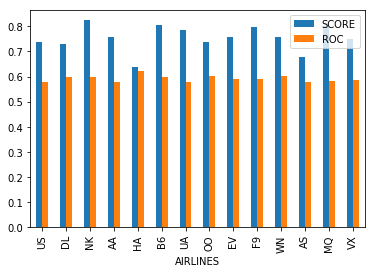

In [80]:
dfObj.plot(kind='bar',x='AIRLINES')

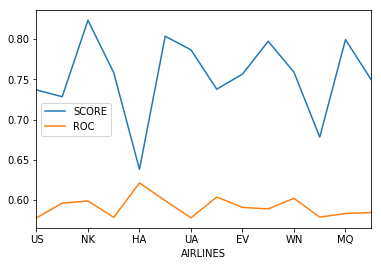

In [81]:
dfObj.plot(kind='line',x='AIRLINES')